### CNN(Convolutional Neural Network) Text Classification
* 참고 사이트: https://wikidocs.net/book/2155

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

In [ ]:
# 훈련 및 검증 데이터 불러오기
urllib.request.urlretrieve('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', filename='ratings_train.txt' )
urllib.request.urlretrieve('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', filename='ratings_test.txt' )

('ratings_test.txt', <http.client.HTTPMessage at 0x79a8010d7400>)

In [ ]:
train_dataset = pd.read_table('ratings_train.txt')
train_dataset

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# pos, neg 비율
train_dataset['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [ ]:
sum(train_dataset['document'].isnull())

5

In [ ]:
~train_dataset['document'].isnull()

0         True
1         True
2         True
3         True
4         True
          ... 
149995    True
149996    True
149997    True
149998    True
149999    True
Name: document, Length: 150000, dtype: bool

In [ ]:
train_dataset = train_dataset[~train_dataset['document'].isnull()]

In [ ]:
sum(train_dataset['document'].isnull())

0

In [ ]:
train_dataset

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### Tokenization
* 자연어를 모델이 이해하기 위해서는 자연어를 숫자의 형식으로 변형 시켜야 함

In [ ]:
train_dataset['document'].iloc[0].split()

['아', '더빙..', '진짜', '짜증나네요', '목소리']

In [ ]:
vocab = set()
for doc in train_dataset['document']:
    for token in doc.split():
        vocab.add(token)

In [ ]:
len(vocab)

357862

In [ ]:
# 단어의 빈도수 구하기
vocab_cnt_dict = {}
for doc in train_dataset['document']:
    for token in doc.split():
        if token not in vocab_cnt_dict:
            vocab_cnt_dict[token] = 0
        vocab_cnt_dict[token] += 1

In [ ]:
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]

In [ ]:
vocab_cnt_list[:10]

[('아', 1204),
 ('더빙..', 2),
 ('진짜', 5929),
 ('짜증나네요', 10),
 ('목소리', 99),
 ('흠...포스터보고', 1),
 ('초딩영화줄....오버연기조차', 1),
 ('가볍지', 17),
 ('않구나', 2),
 ('너무재밓었다그래서보는것을추천한다', 1)]

In [ ]:
top_vocabs = sorted(vocab_cnt_list, key=lambda tup:tup[1], reverse=True)

In [ ]:
top_vocabs[:10]

[('영화', 10825),
 ('너무', 8239),
 ('정말', 7791),
 ('진짜', 5929),
 ('이', 5059),
 ('영화.', 3598),
 ('왜', 3285),
 ('더', 3260),
 ('이런', 3249),
 ('그냥', 3237)]

In [ ]:
cnts = [cnt for _, cnt in top_vocabs]

In [ ]:
np.mean(cnts)

3.1792590439890236

In [ ]:
cnts[:10]

[10825, 8239, 7791, 5929, 5059, 3598, 3285, 3260, 3249, 3237]

In [ ]:
sum(np.array(cnts) > 2)

42635

In [ ]:
n_vocab = sum(np.array(cnts) > 2)

In [ ]:
top_vocabs_truncated = top_vocabs[:n_vocab]

In [ ]:
top_vocabs_truncated[:5]

[('영화', 10825), ('너무', 8239), ('정말', 7791), ('진짜', 5929), ('이', 5059)]

In [ ]:
vocabs = [token for token, _ in top_vocabs_truncated]
vocabs[:5]

['영화', '너무', '정말', '진짜', '이']

### special token
* [UNK]: Unknown token
* [PAD]: Padding token

In [ ]:
unk_token = '[UNK]'
unk_token in vocabs

False

In [ ]:
pad_token = '[PAD]'
pad_token in vocabs

False

In [ ]:
vocabs.insert(0, unk_token)
vocabs.insert(0, pad_token)

In [ ]:
vocabs[:5]

['[PAD]', '[UNK]', '영화', '너무', '정말']

In [ ]:
idx_to_token = vocabs
token_to_idx = {token: i for i, token in enumerate(idx_to_token)}

In [ ]:
class Tokenizer:
    def __init__(self, vocabs, use_padding=True, max_padding=64, pad_token='[PAD]', unk_token='[UNK]'):
        self.idx_to_token = vocabs
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
        self.use_padding = use_padding
        self.max_padding = max_padding
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.unk_token_idx = self.token_to_idx[self.unk_token]
        self.pad_token_idx = self.token_to_idx[self.pad_token]

    def __call__(self, x:str):
        token_ids = []
        token_list = x.split()

        for token in token_list:
            if token in self.token_to_idx:
                token_idx = self.token_to_idx[token]
            else:
                token_idx = self.unk_token_idx
            token_ids.append(token_idx)

        if self.use_padding:
            token_ids = token_ids[:self.max_padding]
            n_pads = self.max_padding - len(token_ids)
            token_ids = token_ids + [self.pad_token_idx] * n_pads

        return token_ids

In [ ]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [ ]:
sample = train_dataset['document'].iloc[0]
print(sample)

아 더빙.. 진짜 짜증나네요 목소리


In [ ]:
tokenizer(sample) # [51, 1, 5, 10485, 1064]

[51, 1, 5, 10485, 1064]

In [ ]:
token_length_list = []
for sample in train_dataset['document']:
    token_length_list.append(len(tokenizer(sample)))

Text(0, 0.5, 'count')

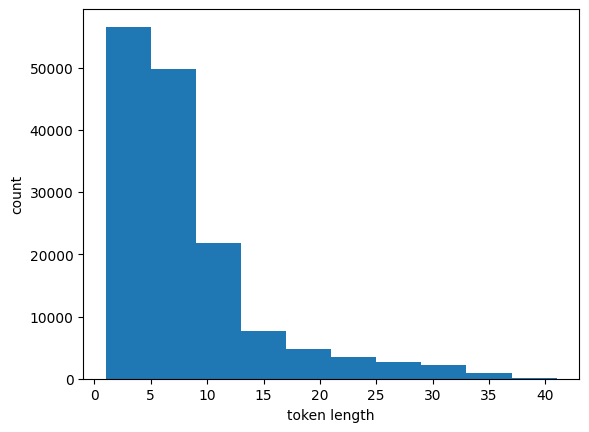

In [ ]:
plt.hist(token_length_list)
plt.xlabel('token length')
plt.ylabel('count')

In [ ]:
max(token_length_list)

41

In [ ]:
tokenizer = Tokenizer(vocabs, use_padding=True, max_padding=50)

In [ ]:
print(tokenizer(sample))

[201, 2, 3635, 1, 121, 1946, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
train_valid_dataset = pd.read_table('ratings_train.txt')
test_dataset = pd.read_table('ratings_test.txt')

In [ ]:
print(f'train, valid samples: {len(train_valid_dataset)}')
print(f'test samples: {len(test_dataset)}')

train, valid samples: 150000
test samples: 50000


In [ ]:
train_valid_dataset.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 데이터프레임을 무작위로 섞기
train_valid_dataset = train_valid_dataset.sample(frac=1.)
train_valid_dataset.head()

,id,document,label
90857,8205176,윤아 졸귀ㅋㅋ 게다가 연기도 늘었음ㄷㄷ 윤아 대다나다,1
79311,2848435,학구열을 불태우는 영화 별거아닌 소재로 이런 통쾌함과 감동을 준다는게 인상깊었음,1
114364,9996910,진짜 연기도 잘하고 너무 생생함재미잏는 권투까지 10점안주면..,1
68668,9323837,모든 사랑은 매번 정점 같을 순 없다. 그것을 변화가 아닌 흐름이라고 생각한다면 넓...,1
74209,4487921,이런걸 왜 만들었나...돈 아깝다...,0


In [ ]:
# train_valid_dataset | 훈련 데이터셋(80%) 검증 데이터셋(20%)
train_ratio = 0.8
n_train = int(len(train_valid_dataset) * train_ratio)
train_df = train_valid_dataset[:n_train]
valid_df = train_valid_dataset[n_train:]
test_df = test_dataset

In [ ]:
print(f'train samples: {len(train_df)}')
print(f'valid samples: {len(valid_df)}')
print(f'test samples: {len(test_df)}')

train samples: 120000
valid samples: 30000
test samples: 50000


In [ ]:
# 1/10으로 샘플링
train_df = train_df.sample(frac=0.8)
valid_df = valid_df.sample(frac=0.8)
test_df = test_df.sample(frac=0.8)

In [ ]:
print(f'train samples: {len(train_df)}')
print(f'valid samples: {len(valid_df)}')
print(f'test samples: {len(test_df)}')

train samples: 96000
valid samples: 24000
test samples: 40000


In [ ]:
# 클래스 : NSMCDataset   훈련, 검증 및 테스트 데이터셋을 생성
class NSMCDataset(Dataset):
    def __init__(self, data_df, tokenizer=None):
        self.data_df = data_df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        sample_raw = self.data_df.iloc[idx]
        sample = {}
        sample['doc'] = str(sample_raw['document'])
        sample['label'] = int(sample_raw['label'])
        if self.tokenizer is not None:
            sample['doc_ids'] = self.tokenizer(sample['doc'])
        return sample

In [ ]:
# 데이터셋 생성(훈련/검증/테스트)
train_dataset = NSMCDataset(data_df=train_df, tokenizer=tokenizer)
valid_dataset = NSMCDataset(data_df=valid_df, tokenizer=tokenizer)
test_dataset = NSMCDataset(data_df=test_df, tokenizer=tokenizer)

In [ ]:
print(train_dataset[0])

{'doc': '라푼젤보다 낫네요. 조금 아쉬운점이 있다면 약간의 산만함이 였어요. 배경 작화도 디지털 이라는게 너무 티가나서 약간은 아쉬웠지만 재밌게봤습니다^~^ 라푼젤 처럼 처음부터 블록버스터 급으로 만들어서 사람들이 더 많이봤으면 더 좋았을걸 그랬습니다.', 'label': 1, 'doc_ids': [1, 29832, 184, 39888, 772, 1318, 25654, 17137, 1956, 9941, 15325, 1, 3, 1, 3983, 4382, 1, 1, 953, 363, 3795, 25606, 1675, 279, 9, 1, 9, 14074, 40511, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
# 함수: collate_fn  여러 샘플을 하나의 배치(batch)로 병합
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}
    for item in batch:
        for key in keys:
            data[key].append(item[key])
    return data

In [ ]:
# DataLoader  |  훈련 / 검증 / 테스트 데이터셋을 배치로 로드
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False
)

In [ ]:
# 문서 / 레이블 /  토큰화된 문서 ID  (토크나이저가 주어진 경우) 출력
sample = next(iter(test_dataloader))
# test_dataloader에서 iter() 함수를 사용하여 반복자(iterator)를 생성
# next() 함수를 사용하여 첫 번째 배치를 가져옴

In [ ]:
sample.keys()   # dict_keys(['doc', 'label', 'doc_ids'])

dict_keys(['doc', 'label', 'doc_ids'])

In [ ]:
sample['doc'][3]

'진심 지루함 스토리도 없고 ㅡㅡ'

In [ ]:
print(sample['doc_ids'][3])

[182, 606, 132, 61, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### CNN Model

참고페이지
* 딥 러닝을 이용한 자연어 처리 입문: https://wikidocs.net/book/2155
* N-gram 언어 모델(N-gram Language Model): https://wikidocs.net/21692

In [ ]:
#  클래스 :  SentenceCNN
# 합성곱 신경망(Convolutional Neural Network, CNN)을 활용하여 문장을 처리하는 모델
class SentenceCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, word_win_size=[3, 5, 7]):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.word_win_size = word_win_size

        self.conv_list = nn.ModuleList(
            [nn.Conv2d(1, 1, kernel_size=(w, embed_dim)) for w in self.word_win_size]
        )

        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.output_dim = len(self.word_win_size)

    def forward(self, X):
        batch_size, seq_len = X.size()
        X = self.embeddings(X)  # batch_size * seq_len * embed_dim
        X = X.view(batch_size, 1, seq_len, self.embed_dim) # batch_size * channel(1) * seq_len(H) * embed_dim(W)
        C = [F.relu(conv(X)) for conv in self.conv_list] # 각 단어 윈도우 크기에 대해 Conv2d 레이어를 통과시키고 활성화 함수 ReLU를 적용하여 출력을 계산
        C_hat = torch.stack([F.max_pool2d(
            c, c.size()[2:]).squeeze() for c in C], dim=1) # 각 Conv2d 레이어의 출력에서 최대 풀링을 적용하여 최대 풀링 값들을 스택으로 쌓음
        return C_hat

In [ ]:
class Classifier(nn.Module):
    def __init__(self, sr_model, output_dim, vocab_size, embed_dim, **kwargs):
        super().__init__()
        self.sr_model = sr_model(vocab_size=vocab_size, embed_dim=embed_dim, **kwargs)
        self.input_dim = self.sr_model.output_dim
        self.output_dim = output_dim
        self.fc = nn.Linear(self.input_dim, self.output_dim)

    def forward(self, x):
        return self.fc(self.sr_model(x))

In [ ]:
# CNN 모델을 사용하여 단어 임베딩을 구성하고, 이를 기반으로 분류를 수행
model = Classifier(sr_model=SentenceCNN, output_dim=2, vocab_size=len(vocabs), embed_dim=16)

In [ ]:
model.sr_model.embeddings.weight[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

In [ ]:
# CUDA 사용 가능 여부를 확인, 가능한 경우 모델을 GPU로 이동
use_cuda = True and torch.cuda.is_available()

if use_cuda:
    model.cuda()

In [ ]:
# 학습에 필요한 최적화 함수와 손실 함수를 설정
# Adam 최적화 알고리즘은 모델 파라미터를 업데이트,
# CrossEntropyLoss는 모델의 출력과 실제 레이블 간의 손실을 계산, 이를 최소화하는 방향으로 학습이 진행
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
calc_loss = nn.CrossEntropyLoss()

In [ ]:
# 모델을 학습 / 검증 | 최적의 모델을 선택하는 과정
# 학습 중에는 훈련 데이터셋을 사용하여 모델을 업데이트,
# 검증 데이터셋을 사용하여 모델의 성능을 평가
n_epoch = 10
global_i = 0

valid_loss_history = []
train_loss_history = []

best_model = None
best_epoch_i = None
min_valid_loss = 9e+9

for epoch_i in range(n_epoch):
    model.train()

    for batch in train_dataloader:
        optimizer.zero_grad()
        X = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])

        if use_cuda:
            X = X.cuda()
            y = y.cuda()

        y_pred = model(X)
        loss = calc_loss(y_pred, y)

        if global_i % 1000 == 0:
            print(f'i: {global_i}, epoch: {epoch_i}, loss: {loss.item()}')

        train_loss_history.append((global_i, loss.item()))

        loss.backward()
        optimizer.step()
        global_i += 1

    model.eval()

    valid_loss_list = []
    for batch in valid_dataloader:
        X = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])

        if use_cuda:
            X = X.cuda()
            y = y.cuda()

        y_pred = model(X)
        loss = calc_loss(y_pred, y)
        valid_loss_list.append(loss.item())

    valid_loss_mean = np.mean(valid_loss_list)
    valid_loss_history.append((global_i, valid_loss_mean.item()))

    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        best_epoch_i = epoch_i
        best_model = deepcopy(model)

    if epoch_i % 2 == 0:
        print("*"*30)
        print(f'valid_loss_mean: {valid_loss_mean}')
        print("*"*30)

print(f'best_epoch: {best_epoch_i}')

i: 0, epoch: 0, loss: 0.6884323358535767
******************************
valid_loss_mean: 0.47299464474967184
******************************
i: 1000, epoch: 1, loss: 0.394570529460907
i: 2000, epoch: 2, loss: 0.2906910181045532
******************************
valid_loss_mean: 0.4969534585450558
******************************
i: 3000, epoch: 4, loss: 0.19278323650360107
******************************
valid_loss_mean: 0.6206072825700679
******************************
i: 4000, epoch: 5, loss: 0.2509707510471344
i: 5000, epoch: 6, loss: 0.22671787440776825
******************************
valid_loss_mean: 0.7885838387177345
******************************
i: 6000, epoch: 8, loss: 0.12545064091682434
******************************
valid_loss_mean: 0.8912249467474349
******************************
i: 7000, epoch: 9, loss: 0.18008491396903992
best_epoch: 1


In [ ]:
# 훈련과 검증 손실의 추이를 시각화
def calc_moving_average(arr, win_size=100):
    new_arr = []
    win = []

    for i, val in enumerate(arr):
        win.append(val)
        if len(win) > win_size:
            win.pop(0)

        new_arr.append(np.mean(win))
    return np.array(new_arr)

Text(0, 0.5, 'loss')

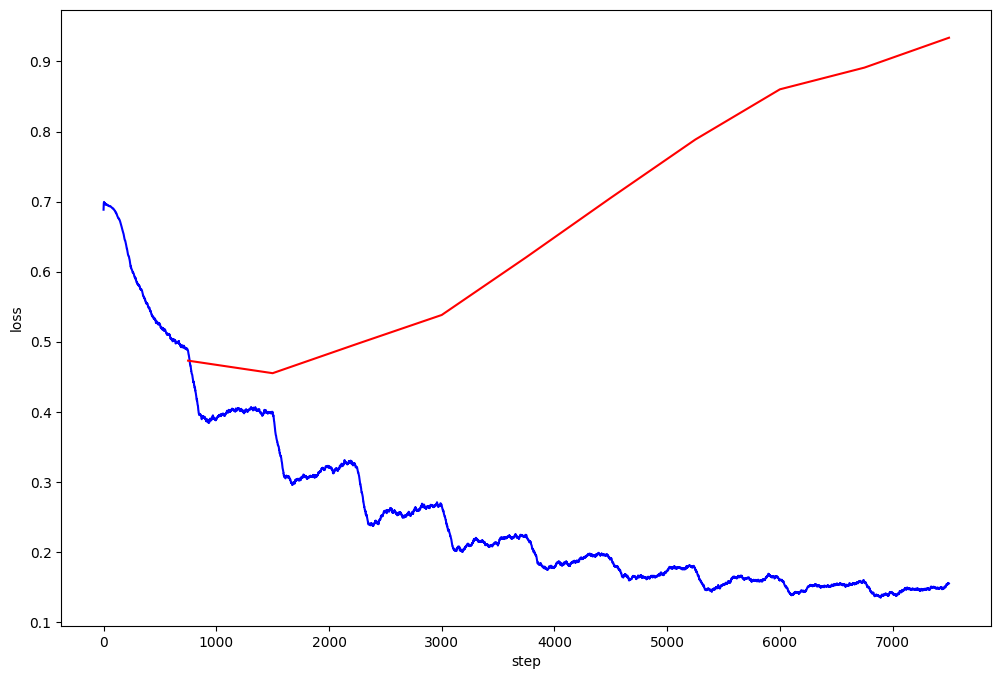

In [ ]:
valid_loss_history = np.array(valid_loss_history)
train_loss_history =  np.array(train_loss_history)

plt.figure(figsize=(12,8))
plt.plot(train_loss_history[:,0],
         calc_moving_average(train_loss_history[:,1]), color='blue')

plt.plot(valid_loss_history[:,0],
         valid_loss_history[:,1], color='red')
plt.xlabel("step")
plt.ylabel("loss")
# valid_loss_history: 점점 과적합됨
# train_loss_history: 성능이 점점 좋아짐

### Evaluation

In [ ]:
# 테스트 데이터셋에서 정확도를 계산
model = best_model

model.eval()

total = 0
correct = 0

for batch in tqdm(test_dataloader,
                  total=len(test_dataloader.dataset)//test_dataloader.batch_size):
    X = torch.tensor(batch['doc_ids'])
    y = torch.tensor(batch['label'])

    if use_cuda:
        X = X.cuda()
        y = y.cuda()

    y_pred = model(X)

    curr_correct = y_pred.argmax(dim=1) == y

    total += len(curr_correct)
    correct += sum(curr_correct)

print(f'test accuracy: {correct/total}')

  0%|          | 0/312 [00:00<?, ?it/s]

test accuracy: 0.768750011920929
